# Vision Transformers implementation from scratch

Author: Alejandro Meza Tudela

## Visualize the data

To test our Vision Transformer implementation, we'll be using the Oxford-IIIT Pet dataset. But first, let's take a quick look at the data!

In [2]:
import torch
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import ToTensor, Resize
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from random import random

100%|██████████| 792M/792M [00:23<00:00, 33.4MB/s] 


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:00<00:00, 19.6MB/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


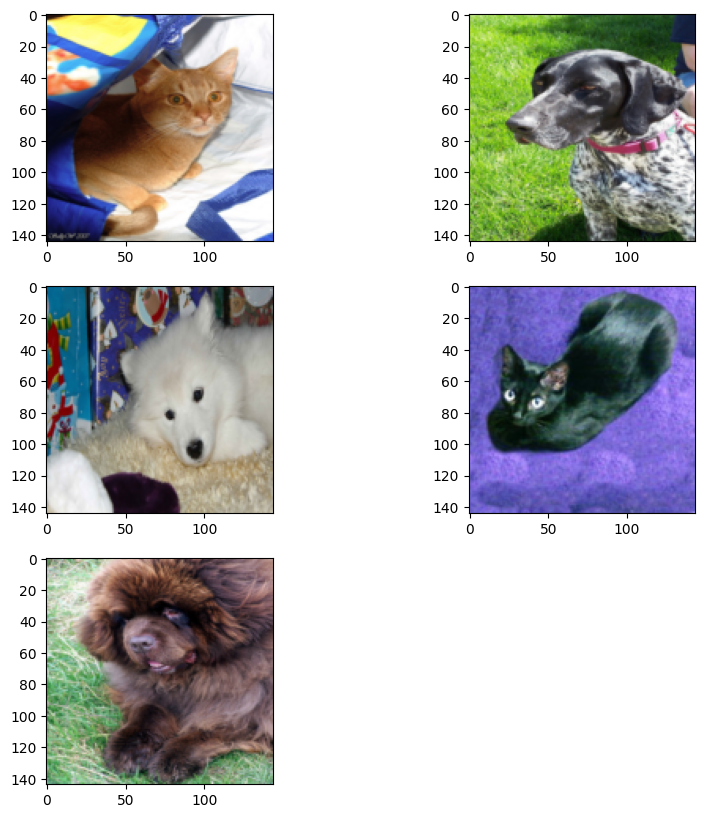

In [3]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target):
        for t in self.transforms:
            img = t(img)
        return img, target

def show_images(images,num_samples=5,cols=2):
    plt.figure(figsize=(10,10))
    idx = int(len(images)/num_samples)
    for i,img in enumerate(images):
      if i%idx==0:
        plt.subplot(int(num_samples/cols)+1,cols,int(i/idx)+1)
        plt.imshow(to_pil_image(img[0]))


to_tensor_transform = [Resize((144,144)),ToTensor()]
#load dataset
dataset = OxfordIIITPet(root='./data', transforms=Compose(to_tensor_transform), download=True)
#show sample images
show_images(dataset)

## Patching module

This module represents the **first step** in the Vision Transformer (ViT) architecture.  
Its main purpose is to transform the input image into a **sequence of patches**, which can then be fed into a standard Transformer architecture.

The patching process has the following characteristics:

- The number of patches extracted from the image is calculated as:  
  **N = (H × W) / (P × P)**  
  where:
  - `H` and `W` are the height and width of the input image,
  - `P` is the patch size.

- Once the image is divided into patches, each patch is **reprojected** (in this case via a linear layer or convolution) to a fixed **embedding dimension**. This ensures compatibility with the Transformer’s expected input format.

In [17]:
import torch.nn as nn

class PatchEmbedding(nn.Module):
  '''
    Parameters:
    in_channels: number of channels of the input image
    patch_size: size of the patch
    emb_size: size of the embedding vector
    img_size: size of the image
  '''
  def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=144):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    #define the number of the patches according the paper proposal (non-overlapping)
    self.n_patches = (img_size // patch_size) ** 2
    '''
      use a convolution layer to map the patches into the desire embedding
      dimension
    '''
    self.projection = nn.Conv2d(in_channels,
                                emb_size,
                                kernel_size=patch_size,
                                stride=patch_size)

  def forward(self,x):
    '''
      Input: (Batch_size,in_channels,height_image,weigth_image)
      Output: (Batch_size,number_of_patches,emb_size)
    '''
    x = self.projection(x)
    #print(f'Dimension of the projected patch {x.shape}')
    x = x.flatten(2)  # (Batch_size,emb_size,number_of_patches)
    x = x.transpose(1,2) # (Batch_sizeB,number_of_patches, emb_size)
    return x

In [6]:
#now, it's time to try this module!!
sample_image = dataset[0][0]
print(f'The dimensions of the input image is {sample_image.shape}')
patch_embedding = PatchEmbedding()
patch_embedding(sample_image.unsqueeze(0)).shape

The dimensions of the input image is torch.Size([3, 144, 144])
Dimension of the projected patch torch.Size([1, 768, 9, 9])


torch.Size([1, 81, 768])

As we can see, the following transformation has taken place:

- The input image with dimensions **[3, 144, 144]** (Channels × Height × Width)  
  has been divided into **9 patches**, since each patch covers an area of **16×16 pixels**.

- Each patch is then **reprojected** into the desired **embedding dimension of 768**.  
  This results in a tensor of shape **[768, 9, 9]** (Embedding Dim × Patch Grid Height × Patch Grid Width).

Everything has worked as expected up to this step!

## Attention module

This class implements the Multi-Head Self-Attention mechanism, a core component of the Vision Transformer (ViT) architecture.
It follows the same principle introduced in the Attention Is All You Need paper, where the input sequence is projected into Query (Q), Key (K), and Value (V) vectors. These vectors are split across multiple heads to allow the model to jointly attend to information from different representation subspaces.

In [7]:
class Attention(nn.Module):
  '''
    Parameters:
    emb_size: size of the embedding vector
    num_heads: number of attention heads
    qkv_bias: determine if we include bias into the k,q,v projection layers
    att_dropout_prob: dropout rate applied to the query,value,key matrices
    proj_dropout_prob: dropout rate applied to the output of the attention heads
  '''
  def __init__(self, emb_size=768,
               num_heads=12,
               qkv_bias=True,
               att_dropout_prob=0,
               proj_dropout_prob=0,
               debug=False):
    super().__init__()
    #determine the variables of the class
    self.emb_size = emb_size
    self.num_heads= num_heads
    self.head_dim = emb_size // num_heads
    self.scale = self.head_dim ** -0.5 # Scaling factor from "Attention is All You Need"
    self.debug = debug

    self.qkv = nn.Linear(emb_size, emb_size * 3, bias=qkv_bias)
    self.att_dropout = nn.Dropout(att_dropout_prob)
    self.projection = nn.Linear(emb_size, emb_size)
    self.proj_dropout = nn.Dropout(proj_dropout_prob)

  def forward(self,x):
    '''
      Input: (number_samples,number_of_patches+1,emb_size)
      Output: (number_samples,number_of_patches+1,emb_size)
    '''
    samples_per_batch,number_of_patches,emb_size = x.shape
    if emb_size!=self.emb_size: raise ValueError
    qkv = self.qkv(x) #output dimension: (samples,num_patches+1,emd_size*3)
    #print(f'QKV shape: {qkv.shape}')
    #for each patch, we have 3 vectors v,k,q, which are divided into a certain number of heads
    qkv = qkv.reshape(samples_per_batch,
                      number_of_patches,
                      3,
                      self.num_heads,
                      self.head_dim)
    #print(qkv.shape)
    #since we wanna apply the linear layer againts the qkv output, is a must to reshape the qkv variable
    qkv = qkv.permute(2,0,3,1,4) #output dimension: (samples,3,num_patches+1,num_heads,head_dim)
    #obtain the individual matrices
    q,k,v = qkv[0],qkv[1],qkv[2]
    if self.debug:
      print(f'Q shape: {q.shape}, K shape:{k.shape}, V shape: {v.shape}')
    k_t = k.transpose(-2,-1)
    #compute the dot product of the attention mechanism
    dot_product = (q @ k_t) * self.scale
    #print(f'Dot product shape: {dot_product.shape}')
    attention = dot_product.softmax(dim=-1) #apply softmax over the last dimension
    attention = self.att_dropout(attention)
    #print(f'Attention shape: {attention.shape}')
    #finally, is time to compute the output weights
    weighted_avg = attention @ v # (samples,number_heads,num_patches+1,head_dim)
    weighted_avg = weighted_avg.transpose(1,2) #(samples, num_patches+1, number_heads,head_dim)
    weighted_avg = weighted_avg.flatten(2) # flatten the last 2 dimensions
    #print(f'Weighted avg shape: {weighted_avg.shape}')
    #last step, compute the last linear projection
    x = self.projection(weighted_avg)
    x = self.proj_dropout(x)
    return x

## Multilayer perceptron module

This module defines a Feedforward Neural Network block — commonly used in Transformer architectures, including Vision Transformers (ViT).
The MLP operates independently on each token (or patch embedding) and is responsible for learning complex feature transformations after the self-attention step.

In [8]:
class MLP(nn.Module):
  '''
  Parameters:
  in_features: number of input features
  hidden_features: number of hidden features
  out_features: number of output features
  p: dropout rate
  '''
  def __init__(self, in_features, hidden_features, out_features, p=0.1):
    super().__init__()
    #first linear layer
    self.linear_layer_1 = nn.Linear(in_features, hidden_features)
    self.activation_layer_1 = nn.GELU()
    #second linear layer
    self.linear_layer_2 = nn.Linear(hidden_features, out_features)
    #dropout to prevent overfitting
    self.dropout_layer = nn.Dropout(p)

  def forward(self,x):
    x = self.linear_layer_1(x)
    x = self.activation_layer_1(x)
    x = self.dropout_layer(x) #dropout after first layer
    x = self.linear_layer_2(x)
    x = self.dropout_layer(x) #dropout after second layer
    return x

## Define the Vision Transformers block

After implementing all the necessary components of the Vision Transformer architecture, it's time to combine them into a single **encoder block**.  
This block will include the following elements:

- **Two Layer Normalization layers**
- **Multi-Head Self-Attention (MHSA)** module
- **Multilayer Perceptron (MLP)**

Each of these components plays a critical role in enabling the model to learn meaningful representations from the input patch embeddings.

In [9]:
class Block(nn.Module):
  '''
  Parameters:
  emb_size: size of the embedding vector
  num_heads: number of attention heads
  mlp_ratio: ratio of the hidden features in the MLP
  qkv_bias: determine if we include bias into the k,q,v projection layers
  p,att_dropout_prob: dropout probability
  '''
  def __init__(self, emb_size=768, num_heads=12, mlp_ratio=4.0, qkv_bias=True, p=0., att_dropout_prob=0.):
    super().__init__()
    self.norm1 = nn.LayerNorm(emb_size, eps=1e-6)
    self.attention = Attention(emb_size, num_heads, qkv_bias, att_dropout_prob, p,False)
    self.norm2 = nn.LayerNorm(emb_size, eps=1e-6)
    hidden_features = int(emb_size * mlp_ratio)
    self.mlp = MLP(in_features=emb_size, hidden_features=hidden_features, out_features=emb_size)

  def forward(self,x):
    #First residual block
    x = x+self.attention(
        self.norm1(x)
    )
    #Second residual block
    x = x+self.mlp(
        self.norm2(x)
    )
    return x

## Vision Transformer Implementation (VIT)

This is the full Vision Transformer model that utilizes the `Block` class defined earlier as its core
encoder unit. Each `Block` represents one Transformer encoder layer, consisting of:
- Multi-head self-attention
- MLP with hidden expansion
- Layer normalization and residual connections

The ViT architecture is composed of multiple such `Block`s stacked sequentially to encode the input patch tokens.
These tokens are generated from the image using a `PatchEmbedding` module, and a learnable [CLS] token is used
to aggregate the global representation, which is later used for classification.

This model wraps all components into a complete, end-to-end vision transformer pipeline.

In [18]:
class VisionTransformer(nn.Module):
  '''
    Parameters:
    img_size: size of the image
    patch_size: size of the patch
    img_channels: number of channels of the input image
    num_classes: number of classes
    emb_size: size of the embedding
    num_blocks: number of blocks
    num_heads: number of attention heads
    mlp_ratio: ratio of the hidden features in the MLP
    qkv_bias: determine if we include bias into the k,q,v projection layers
    p,att_dropout_prob: dropout probability
  '''
  def __init__(self,
               img_size=144,
               patch_size=16,
               img_channels=3,
               num_classes=10,
               emb_size=768,
               num_blocks=12,
               num_heads=12,
               mlp_ratio=4,
               qkv_bias=True,
               p = 0,
               att_dropout=0
              ):
    super().__init__()
    #define the patching process in the beggening to convert the input images into patches sequences
    self.patch_embedding = PatchEmbedding(img_channels, patch_size, emb_size, img_size)
    #define the cls token, which is gonna hold the prediction class
    self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
    #define the positional embedding
    self.pos_embedding = nn.Parameter(torch.zeros(1, 1 + self.patch_embedding.n_patches, emb_size))
    # Dropout applied after adding positional encoding
    self.dropout = nn.Dropout(p)
    #define the blocks of the Vision Transformer
    self.blocks = nn.ModuleList(
        [Block(emb_size, num_heads, mlp_ratio, qkv_bias, p, att_dropout) for _ in range(num_blocks)]
    )
    #add the final layers
    self.norm = nn.LayerNorm(emb_size, eps=1e-6)
    self.head = nn.Linear(emb_size, num_classes) #map the embedding dimensions to the target classes

    #initialization of learnable parameters
    self._init_weights()

  #method to initialize the weights in a stable way to help training convergence
  def _init_weights(self):
    nn.init.trunc_normal_(self.cls_token, std=0.02)
    nn.init.trunc_normal_(self.pos_embedding, std=0.02)
    nn.init.trunc_normal_(self.head.weight, std=0.02)
    if self.head.bias is not None:
      nn.init.zeros_(self.head.bias)

  def forward(self,x):
    x = self.patch_embedding(x)
    batch_size = x.shape[0]
    cls_token = self.cls_token.expand(batch_size, -1, -1) #create cls tokens for all the samples
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.pos_embedding #add the positional embedding
    x = self.dropout(x)

    for vision_transformer_block in self.blocks:
      x = vision_transformer_block(x)

    x = self.norm(x)
    cls_token_final_layer = x[:, 0] #obtain the cls token from the final layer
    x = self.head(cls_token_final_layer)
    return x

## Verifying the Implementation

To verify the model's functionality, we will run at least one training epoch.

In [11]:
!pip install torchinfo

In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader

# 37 classes in OxfordIIITPet dataset
model = VisionTransformer(img_size=144, patch_size=16, emb_size=768, num_classes=37)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'The model is located in {device}')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

The model is located in cuda


In [20]:
from torchinfo import summary
summary(
    model,
    input_size=(1, 3, 144, 144),  # batch size 1, 3 channels, 144x144 image
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    col_width=25,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Kernel Shape
VisionTransformer (VisionTransformer)              [1, 3, 144, 144]          [1, 37]                   63,744                    --
├─PatchEmbedding (patch_embedding)                 [1, 3, 144, 144]          [1, 81, 768]              --                        --
│    └─Conv2d (projection)                         [1, 3, 144, 144]          [1, 768, 9, 9]            590,592                   [16, 16]
├─Dropout (dropout)                                [1, 82, 768]              [1, 82, 768]              --                        --
├─ModuleList (blocks)                              --                        --                        --                        --
│    └─Block (0)                                   [1, 82, 768]              [1, 82, 768]              --                        --
│    │    └─LayerNorm (norm1)                      [1, 82, 7

In [21]:
#define the dataloader
batch_size = 32
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

In [22]:
num_epochs = 1  # You can change this to your desired number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(dataloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights

        running_loss += loss.item()

        if i % 10 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    print(f"Epoch {epoch + 1} completed")

print("Finished Training")

Epoch 1 completed
Finished Training


We have successfully implemented the Vision Transformer (ViT) model from scratch. The architecture is now correctly structured and ready for experimentation or further extension!

**References**
1. Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N.  
   **"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale."**  
   *arXiv preprint arXiv:2010.11929* (2020).  
   [🔗 Read the Paper](https://arxiv.org/pdf/2010.11929)

2. mildlyoverfitted — **Vision Transformer in PyTorch**  
   YouTube tutorial, 2021.  
   [▶️ Watch the Video](https://www.youtube.com/watch?v=ovB0ddFtzzA&t=763s)